##  Neural Network
A description of neural networks can be found [here](https://ml-cheatsheet.readthedocs.io/en/latest/nn_concepts.html)

In [1]:
import numpy as np
import random as rn
import tensorflow as tf
import os
seed = 42
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = '0'
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, confusion_matrix
from keras.models import Model, load_model
from keras.layers import Input, Dense, RNN
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers

/Users/tobi/anaconda3/envs/datascience/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/tobi/anaconda3/envs/datascience/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/tobi/anaconda3/envs/datascience/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Prints the metrics that we're going to use to evaluate classifier performance.
def my_test_results(model, X, Y):
    pred_raw = pd.DataFrame(autoencoder.predict(X))
    pred_raw = pred_raw[0] < pred_raw[1]

    cm = confusion_matrix((Y == 1), pred_raw, labels=[0,1])
    accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
    precision = float(cm[1,1]/(cm[1,1]+cm[0,1]))
    recall = float(cm[1,1]/(cm[1,1]+cm[1,0]))
    f1 = (2.0*precision*recall)/(precision+recall)
    print("Out of sample accuracy = %4.3f" % accuracy)
    print("Out of sample precision = %4.3f" % precision)
    print("Out of sample recall = %4.3f" % recall)
    print("Out of sample F1 = %4.3f" % f1)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])

### Import Data

* Load data
* Remove useless columns and records (only CASH_OUT and TRANSFER have fraud).
* Remap transfer to 0/1.

In [3]:
df = pd.read_csv('../simulated_transactions.csv.xz')
print(df.shape)
df.head()

(1305514, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,2,PAYMENT,18211.33,C1099717276,88.00,0.00,M417557780,0.00,0.00,0,0
1,2,CASH_IN,93240.07,C1350751778,47.00,93287.07,C665576141,12.00,8650239.39,0,0
2,2,CASH_IN,78314.86,C332699949,93287.07,171601.93,C1359044626,178957.00,16435074.66,0,0
3,2,CASH_IN,101282.39,C808417649,171601.93,171601.93,C1599771323,171601.93,3771328.56,0,0
4,2,CASH_IN,24227.29,C858204589,171601.93,195829.22,C353842779,524999.00,872623.24,0,0


### Filtering
Filter out types other than TRANSFER, and CASH_OUT.<br>
Remove variables, 'step', 'nameOrig', 'nameDest', and 'isFlaggedFraud'.

In [4]:
X = df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1).query('type=="CASH_OUT" or type=="TRANSFER"')
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
print(X.shape)

(586965, 7)


### Data Exploration
Normally data exploration would be done here. Looking at the data ranges, distributions and relationships. See the Data Exploration section for examples of this. For the purpose the this notebook we will skip straight to the logistic regression.

## Neural Network
Begin preparing for very simple neural network

### Training Set
Partition the data with an 80/20 split: Training/Testing. <br>
Separate out the dependent variable from the independent varaibles.

In [5]:
train, test = train_test_split(X, test_size=0.4, stratify=X['isFraud'])

Y_train = train['isFraud']
X_train = train.drop(['isFraud'], axis=1)

Y_test = test['isFraud']
X_test = test.drop(['isFraud'], axis=1)

### Simple NN (12,6,6,2)

In [6]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
n = Dense(12, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
n = Dense(6, activation='relu')(n)
n = Dense(6, activation='tanh')(n)
n = Dense(2, activation='softplus')(n)
autoencoder = Model(inputs=input_layer, outputs=n)

nb_epoch = 200
batch_size = int(train.shape[0]/50)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=10,
                          verbose=0, mode='auto')

autoencoder.compile(optimizer='adadelta', 
                    loss='binary_crossentropy', 
                    metrics=['binary_accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)

## Tensorboard is great for diagnostics. We'll leave it out of the example
# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(x=X_train, y=pd.get_dummies(Y_train.values),
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    # callbacks=[checkpointer, tensorboard, earlystop]).history
                    callbacks=[checkpointer, earlystop]).history

Train on 281743 samples, validate on 70436 samples
Epoch 1/200
281743/281743 [==============================] - 1s 5us/step - loss: 9.3623 - binary_accuracy: 0.0982 - val_loss: 9.1603 - val_binary_accuracy: 0.4182
Epoch 2/200
281743/281743 [==============================] - 1s 2us/step - loss: 9.0743 - binary_accuracy: 0.6611 - val_loss: 8.9977 - val_binary_accuracy: 0.9813
Epoch 3/200
281743/281743 [==============================] - 1s 3us/step - loss: 8.9436 - binary_accuracy: 0.9797 - val_loss: 8.8857 - val_binary_accuracy: 0.9822
Epoch 4/200
281743/281743 [==============================] - 1s 2us/step - loss: 8.8412 - binary_accuracy: 0.9823 - val_loss: 8.7941 - val_binary_accuracy: 0.9840
Epoch 5/200
281743/281743 [==============================] - 1s 2us/step - loss: 8.7551 - binary_accuracy: 0.9851 - val_loss: 8.7095 - val_binary_accuracy: 0.9861
Epoch 6/200
281743/281743 [==============================] - 1s 2us/step - loss: 8.6690 - binary_accuracy: 0.9855 - val_loss: 8.6203 -

## Results

Out of sample accuracy = 0.994
Out of sample precision = 0.900
Out of sample recall = 0.636
Out of sample F1 = 0.745


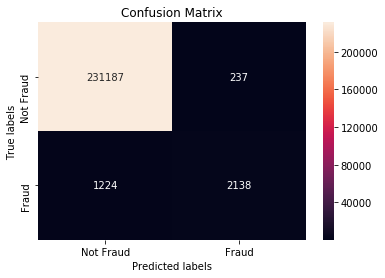

In [7]:
my_test_results(autoencoder, X_test, Y_test)

* Accuracy - Proportion of predictions that are correct. $\frac{True Positive + True Negative}{True Positive + True Negative + False Positive + False Negative}$
* Precision - True positive over total positive actual cases. $\frac{True Positive}{True Positive + False Positive}$
* Recall - True positive over total positive predicted cases. $\frac{True Positive}{True Positive + False Negative}$
* F1 - A balance between Precision and Recall (harmonic mean of precision and recall) $\frac{2 * Precision * Recall}{Precision + Recall}$

Not great, but could certainly improve with tuning.

### Plot loss over iterations
Ordinarly using Tensorboard is best for observing training performance. In this case we'll create a plot to keep it in the notebook.

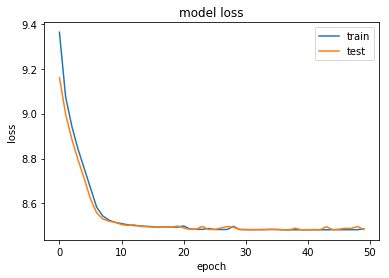

In [8]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Summary
With a small data set a neural network can be more trouble than it's worth. As the volume and complexity of the data increase, however, the value of a neural network dramatically increases.